In [25]:
# MAKE SURE THAT YOU FIND A WAY TO RETURN THE LOSSES IN TEST FOR THIS NOTEBOOK

In [1]:
import os
import sys

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.merfish_dataset import MerfishDataset
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder
from spatial.train import train
from spatial.predict import test

In [2]:
# equivalent to spatial

import hydra
from hydra.experimental import compose, initialize

with initialize(config_path="../config"):
    cfg_from_terminal = compose(config_name="config")
    L1_losses = test(cfg_from_terminal)

/home/roko/.cache/pypoetry/virtualenvs/spatial-1lQwL2nz-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory /home/roko/spatial-main//output/lightning_logs/checkpoints/MonetAutoencoder2D exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
/home/roko/.cache/pypoetry/virtualenvs/spatial-1lQwL2nz-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 9649879.0}
--------------------------------------------------------------------------------


# MAE Imaging

In [3]:
import matplotlib.pyplot as plt

L1_losses[:,0]

TypeError: 'Trainer' object is not subscriptable

#### For a single sample.

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff5b39b2520>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff5b3951a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff5b39580d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff741fa44f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff741fa4850>],
 'means': []}

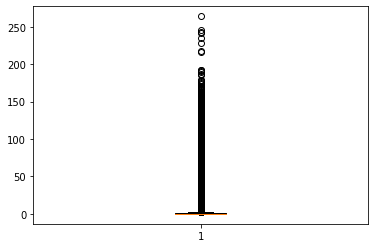

In [6]:
plt.boxplot(L1_losses.reshape(1,-1))

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff72384d9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff7239b70d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff72384d670>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff7239b7790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff7239b7af0>],
 'means': []}

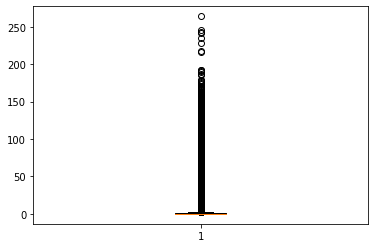

In [20]:
plt.boxplot(L1_losses.reshape(1,-1)[:,:])

In [19]:
import numpy as np

np.mean(L1_losses.numpy())

1.2980286

In [21]:
# Losses for Genes in L/R List

In [ ]:
# Losses for Genes
# 71 mean values 1 for each gene?

In [24]:
L1_losses.mean(axis=0)

tensor([0.5060, 0.5678, 1.9442, 1.5974, 0.6862, 3.0322, 2.2338, 1.5983, 0.5494,
        0.4280, 1.6139, 1.1170, 0.3794, 0.2922, 0.3147, 0.2372, 0.6588, 1.0788,
        0.7413, 1.1305, 1.3543, 3.0416, 1.6116, 0.8487, 1.2961, 2.0827, 1.5092,
        0.7859, 0.8046, 0.7952, 1.0610, 0.5739, 1.4383, 1.3903, 0.4339, 0.6621,
        0.6297, 2.9643, 2.3007, 0.6289, 0.2437, 1.0841, 1.9579, 0.8784, 0.6032,
        5.2654, 1.3384, 1.1522, 0.3562, 0.6971, 1.8015, 1.0175, 2.5321, 1.3247,
        7.5027, 0.7608, 0.8017, 0.3834, 1.5291, 0.5354, 1.8421, 2.4506, 1.8730,
        0.9141, 0.7427, 1.5195, 2.4203, 1.2558, 3.1484, 0.6517, 0.7931, 0.8076,
        0.4693, 0.4736, 0.4988, 1.5466, 1.9514, 0.7112, 0.4609, 2.5930, 1.1476,
        0.8599, 7.3645, 1.3966, 1.6306, 0.8241, 1.4742, 2.2985, 0.7080, 0.8341,
        0.3863, 1.2023, 1.6006, 1.3442, 1.0129, 1.0244, 2.3809, 0.5909, 8.7857,
        1.9511, 1.4216, 1.0561, 1.3719, 1.2436, 1.5701, 2.2202, 0.5750, 1.4699,
        4.3138, 1.6749, 0.6161, 0.6983, 

The code listed below simply generated the response and non-response genes.

In [4]:
# l1_losses = abs(model.inputs - model.gene_expressions)

    # import pandas as pd

    # maxes = {}
    # for i in range(160):
    #     stuff = pd.Series(L1_losses[:,i])
    #     print(round(stuff.describe()[-5:], 3))
    #     stuff = stuff.drop(stuff.idxmax())
    #     try:
    #         maxes[stuff.idxmax()] += 1
    #     except:
    #         maxes[stuff.idxmax()] = 1
    # print(maxes)
    # print("MESSI: " + str([0.37, 0.38, 0.387, 0.389, 0.392]))
    # return trainer
    # non_response_genes = []
    # all_pairs_columns = [
    #     "Ligand.ApprovedSymbol",
    #     "Receptor.ApprovedSymbol",
    # ]
    # df_file = pd.ExcelFile("~/spatial-main/data/messi.xlsx")
    # messi_df = pd.read_excel(df_file, "All.Pairs")
    # merfish_df = pd.read_csv("~/spatial-main/data/merfish.csv")
    # print(messi_df["Ligand.ApprovedSymbol"])
    # for column in all_pairs_columns:
    #     for gene in merfish_df.columns:
    #         if (
    #             gene.upper() in list(messi_df[column])
    #             and gene.upper() not in non_response_genes
    #         ):
    #             non_response_genes.append(gene)
    # print(non_response_genes)
    # print(
    #     "There are "
    #     + str(len(non_response_genes))
    #     + " genes recognized as either ligands or receptors."
    # )